# Forecast of COVID-19 hospitalizations in a French department

In [1]:
%load_ext lab_black
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fbprophet import Prophet
import warnings
import logging

logging.getLogger("fbprophet").setLevel(logging.WARNING)
warnings.filterwarnings("ignore")
pd.plotting.register_matplotlib_converters()

In [3]:
dep = "31"  # Haute-Garonne
nb_days = 4  # forecast horizon (days)
figsize = (12, 7)
covid_url = (
    "https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7"
)

#### <br> Load COVID-19 data of French departments

In [5]:
df = pd.read_csv(covid_url, sep=";", parse_dates=True, index_col=2)
df = df.query("sexe == 0")  # sum male/female
df.drop(columns=["sexe"], inplace=True)
df.sort_index(inplace=True)
df.head(2)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,dep,hosp,rea,rad,dc
jour,,,,,
2020-03-18,01,2,0,1,0
2020-03-18,02,41,10,18,11


#### <br> Plot COVID-19 historical data of the selected department

In [6]:
sdf = df[df["dep"] == dep]

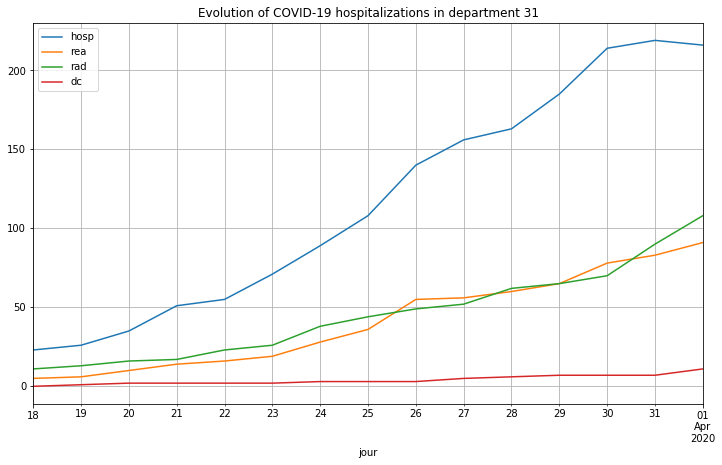

In [7]:
f, ax = plt.subplots(figsize=figsize)
sdf.plot(ax=ax, subplots=False, sharex=True, grid=True)
ax.grid(True, which="both")
ax.set_title("Evolution of COVID-19 hospitalizations in department " + dep)
ax.xaxis.set_label_text("")
img_name = dep + "_historical.png"
f.savefig(img_name)
plt.show()

#### <br> Build vector for Prophet learning

In [8]:
before = sdf.copy()
before = before[["hosp"]]
before.head()

,hosp
jour,
2020-03-18,23
2020-03-19,26
2020-03-20,35
2020-03-21,51
2020-03-22,55


In [9]:
vec = before.copy()
vec = vec.reset_index()
vec = vec[["jour", "hosp"]]
vec.rename(columns={"jour": "ds", "hosp": "y"}, inplace=True)
vec.head(2)

,ds,y
0,2020-03-18,23
1,2020-03-19,26


#### <br> Forecasting with Prophet

In [10]:
m = Prophet(n_changepoints=1)  # changepoints=["2020-04-01"] changepoint_prior_scale=0.1
m.fit(vec)

In [11]:
m.changepoints

11   2020-03-29
Name: ds, dtype: datetime64[ns]

In [12]:
future = m.make_future_dataframe(periods=nb_days)
forecast = m.predict(future)

In [13]:
m.changepoints

11   2020-03-29
Name: ds, dtype: datetime64[ns]

#### <br> Plot forecast and inflection points

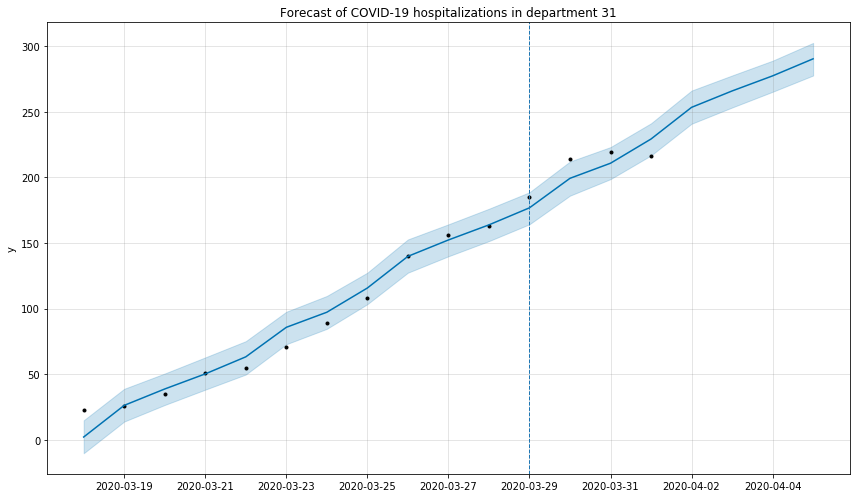

In [14]:
f, ax = plt.subplots(figsize=figsize)
figure = m.plot(forecast, ax=ax)
ax.set_title("Forecast of COVID-19 hospitalizations in department " + dep)
ax.xaxis.set_label_text("")
ax.yaxis.set_label_text("")
for changepoint in m.changepoints:
    plt.axvline(changepoint, ls="--", lw=1)
img_name = dep + "_forecast.png"
f.savefig(img_name)